In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.graph_objs import Scatter, Figure
import torch
from torch import nn

import warnings

```
Написати свій MLP class:
    можна конфігурувати 
        кількість hidden layers
        розміри hidden layers
        Використовувані активації для кожного layer
    клас має бути написаний саме в PyTorch стилі
Взяти модельний/сподобавшийся датасет (але тільки класифікація) (можна sklearn) та побудувати
    Dataset
    Dataloader
    Training loop
```

In [3]:
def input_validator(layers: list[int], activations: list[nn.Module], dropout_rates, batchnorms):
        if len(layers) - 1 != len(activations):
            warnings.warn("Number of activations doesn't correspond to number of layers.")

        if (dropout_rates is not None):
            if (len(dropout_rates) == len(layers)):
                warnings.warn("Number of dropout rates doesn't correspond to number of layers.")
        
        if (batchnorms is not None):
            if (len(batchnorms) == len(layers)):
                warnings.warn("Number of batchnorms doesn't correspond to number of layers.")
        
        # TODO warning if activation func not among activations in torch.nn


## MLP

In [4]:
class MLP(nn.Module):
    def __init__(self, layer_sizes: list[int], activations: list[nn.Module], dropout_rates = None, batchnorms: list[nn.Module] = None):
        # TODO: avoid list[str]
        input_validator(layer_sizes, activations, dropout_rates, batchnorms)   
        super().__init__()
        self.num_layers = len(layer_sizes) - 1
        self.activations = nn.ModuleList(activations)
        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(self.num_layers)
        ])
        
        if (dropout_rates is not None):
            self.dropouts = nn.ModuleList([nn.Dropout(rate) for rate in dropout_rates])
        else:
            self.dropouts = None
            
        if (batchnorms is not None):
            # TODO: generalize!
            self.bns = nn.ModuleList([(el() if el==nn.LazyBatchNorm1d else (None if el==None else el(layer_sizes[i+1]))) for (i, el) in enumerate(batchnorms)])
        else:
            self.bns = None
    
    def forward(self, x):
        for i in range(self.num_layers):
            if ((self.dropouts is not None) and (i < len(self.dropouts))):
                x = self.dropouts[i](x)
                       
            x = self.layers[i](x)
            
            if ((self.bns is not None) and (i < len(self.bns)) and (self.bns[i] is not None)):
                x = self.bns[i](x)
            
            if (i < len(self.activations)):
                x = self.activations[i](x)
                
        if (self.num_layers > len(self.activations)):
            x = nn.Sigmoid()(x)
        return x


## Load data

In [5]:
from torch.utils.data import DataLoader, Dataset, random_split

Let's take more points with more noise.

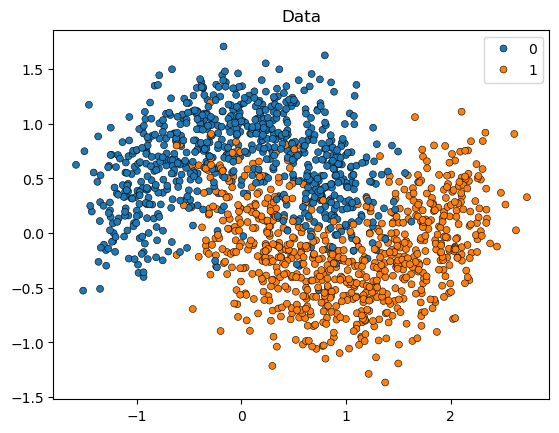

In [6]:
points, labels = make_moons(n_samples=1500, shuffle=True, noise=0.3, random_state=0)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("Data")
plt.show()


## Dataset class and data split

In [7]:
class MyCustomDataset(Dataset):
    def __init__(self, points, labels):
        self.X = torch.tensor(points).float()
        self.y = torch.tensor(labels).reshape(-1, 1).float()
        
    def __len__(self):
        assert(len(self.X) == len(self.y))
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
MyDataset = MyCustomDataset(points, labels)
split_ratio = 0.8

train_size = int(split_ratio * len(MyDataset))
val_size = len(MyDataset) - train_size

# one datasplit for all tests
train_dataset, val_dataset = random_split(MyDataset, [train_size, val_size])

## Testing model

In [9]:
def testModel(
    layers: list[int],
    activations: list[nn.Module],
    dropouts = None,
    batchnorms = None,
    epochs=100,
    lr=1e-3,
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    batch_size=32,
    output=False,
    plot=True,
    debug=False,
    title_addon='',
    plot_type='pyplot'
):
    """
    A supplementary function for convenient testing of MLP with a specific setup.

    Args:
        layers (list[int]): List of integers specifying the number of units in each layer.
        activations (list[nn.Module]): List of activation functions to use in each layer.
        dropouts (list[float], optional): List of dropout rates for each layer, if any. No dropout done if None.
        batchnorms (list[bool or None], optional): List indicating whether to include batch normalization for each layer. No batchnorms applied if None
        epochs (int, optional): Number of training epochs.
        lr (float, optional): Learning rate for the optimizer.
        train_dataset (optional): Dataset used for training.
        val_dataset (optional): Dataset used for validation. No validation completed if None.
        batch_size (int, optional): Size of each training batch.
        output (bool, optional): If True, epoch progress is printed.
        plot (bool, optional): If True, plot the training and validation losses.
        debug (bool, optional): If True, additional debug information is provided.
        title_addon (str, optional): Additional string to append to the plot title.
        plot_type (str, optional): Type of plot to use, 'pyplot' (for GitHub preview) or 'plotly'.

    Returns:
        None: This function does not return anything but may plot or print outputs based on the parameters.
    """
    model = MLP(layers, activations, dropouts, batchnorms)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # if True, validation loss will mesured on each epoch and plotted afterwards
    validate = False if (val_dataset is None) else True
    
    # load training data    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # load val data if validation dataset provided
    if validate:
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    val_losses = []
    
    # iterating trough epochs
    for epoch in range(1, epochs+1):
        if output:
            print(f'{epoch=}')
        
        # training    
        epoch_train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            batch_X, batch_y = batch
            outputs = model(batch_X)
            
            if debug:
                print(f'{outputs.shape=}')
                print(f'{batch_y.shape=}')
                print(batch_y[:5])
                print(outputs[:5])
            
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            
        train_losses.append(epoch_train_loss / len(train_dataloader))
        
        # estimating val loss at current epoch
        if validate:
            epoch_validation_loss = 0
            for batch in val_dataloader:
                with torch.no_grad():
                    batch_X, batch_y = batch
                    outputs = model(batch_X)
                    
                    loss = criterion(outputs, batch_y)
                    epoch_validation_loss += loss.item()
            
            val_losses.append(epoch_validation_loss / len(val_dataloader))
        
    # plotting results
    if (plot):
        if (plot_type == 'pyplot'):
            plt.plot(range(1, epochs+1), train_losses, marker='o', label='Training Loss')

            if validate:
                plt.plot(range(1, epochs+1), val_losses, marker='o', label='Validation Loss')

            plt.title('Training Loss over Epochs ' + title_addon)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
        else:
            train_trace = Scatter(x=list(range(1, epochs+1)), y=train_losses, mode='lines+markers', name='Training Loss')
            if validate:
                val_trace = Scatter(x=list(range(1, epochs+1)), y=val_losses, mode='lines+markers', name='Validation Loss')
                fig = Figure(data=[train_trace, val_trace])
            else:
                fig = Figure(data=[train_trace])
                
            fig.update_layout(title='Training Loss over Epochs ' + title_addon, xaxis_title='Epoch', yaxis_title='Loss')
            fig.show()

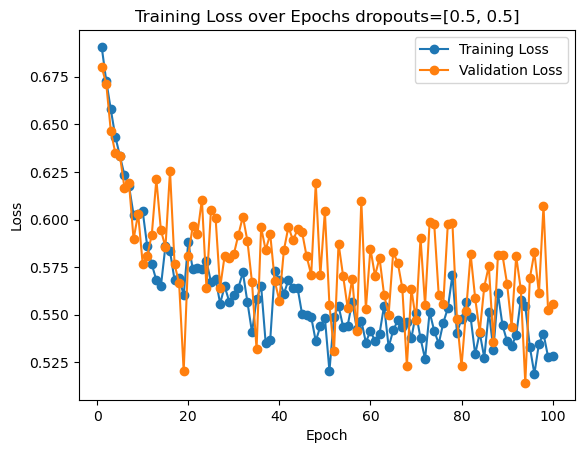

c:\Users\Admin\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


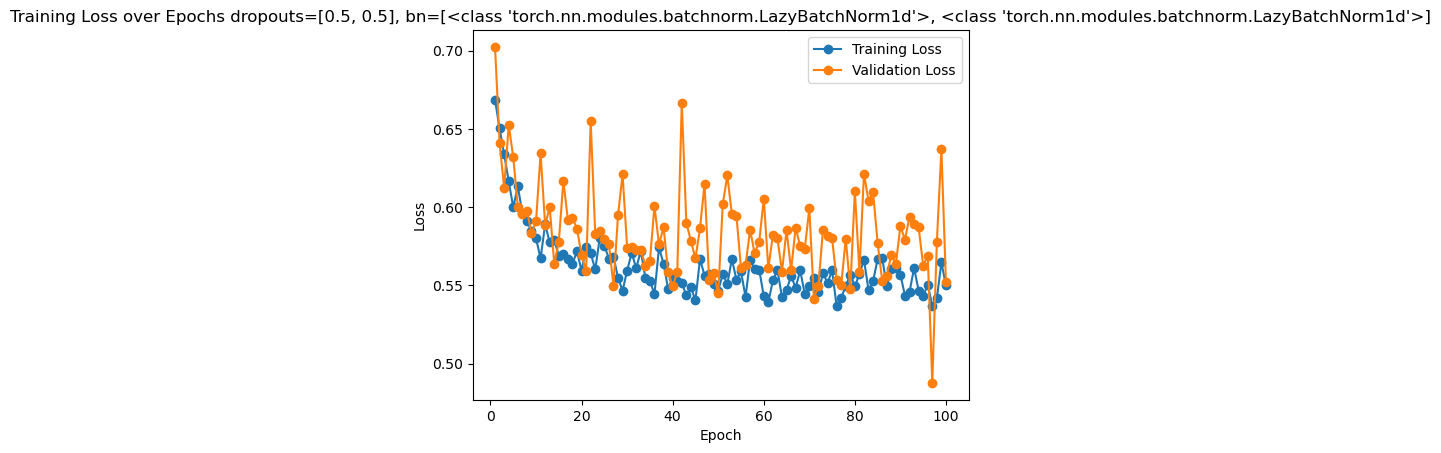

In [10]:
activations = [nn.ReLU(), nn.Sigmoid()]
layers = [2, 5, 1]
dropouts = [0.5, 0.5]
bn = [nn.LazyBatchNorm1d, nn.LazyBatchNorm1d]
testModel(
    layers=layers, 
    activations=activations,
    dropouts=dropouts,
    epochs=100, 
    output=False,
    title_addon=f'{dropouts=}'
    )
testModel(
    layers=layers, 
    activations=activations,
    dropouts=dropouts,
    batchnorms=bn,
    epochs=100, 
    output=False,
    title_addon=f'{dropouts=}, {bn=}'
    )


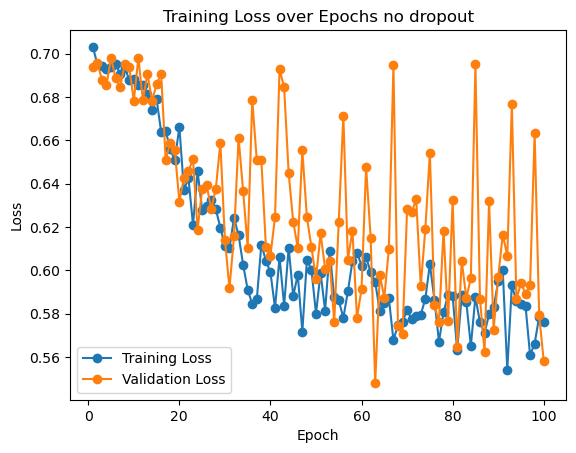

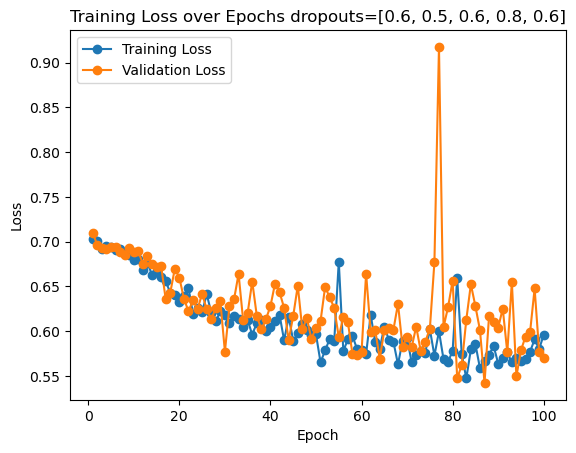

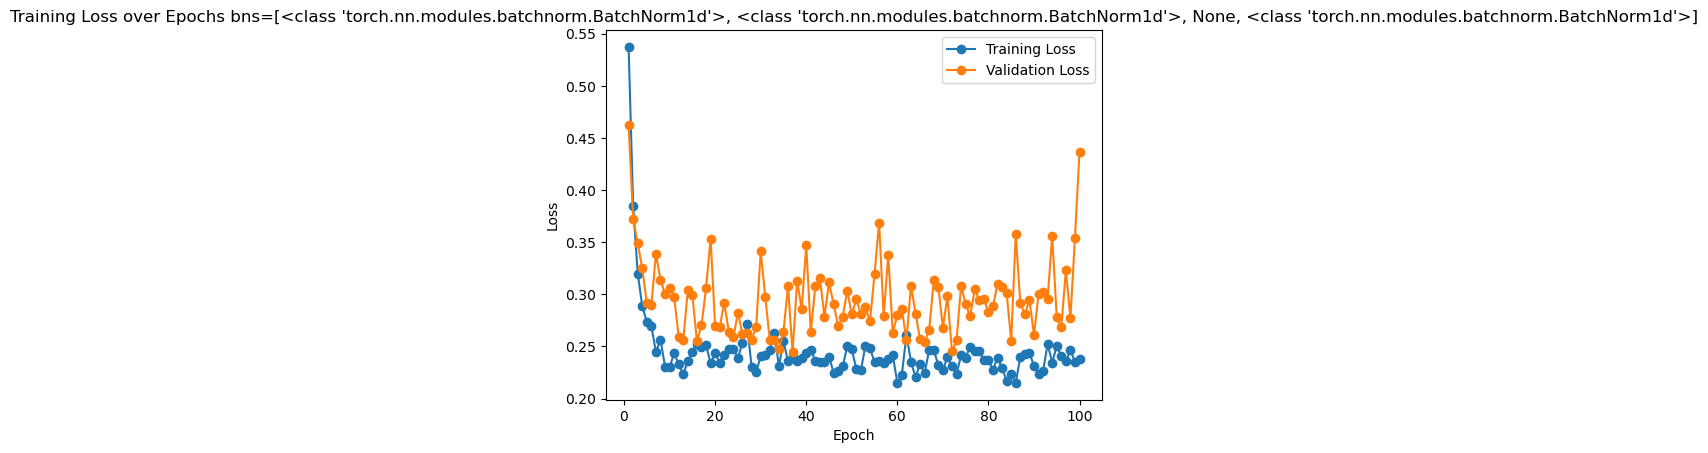

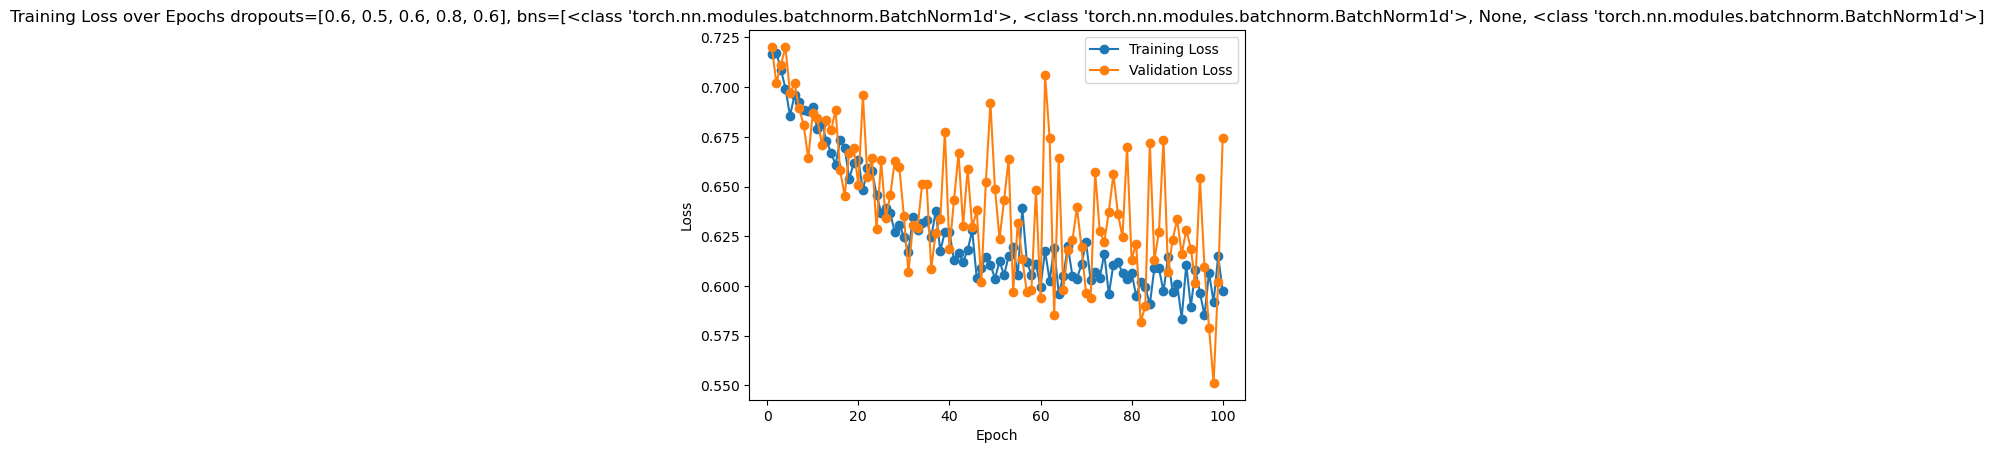

In [11]:
layers = [2, 20, 20, 20, 20, 1]
activations = [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Sigmoid()]
dropouts = [0.6, 0.5, 0.6, 0.8, 0.6]

testModel(
    layers=layers, 
    activations=activations,
    dropouts=dropouts,
    epochs=100, 
    output=False,
    title_addon=f'no dropout',
    )

testModel(
    layers=layers, 
    activations=activations,
    dropouts=dropouts,
    epochs=100, 
    output=False,
    title_addon=f'{dropouts=}',
    )

bns = [nn.BatchNorm1d, nn.BatchNorm1d, None, nn.BatchNorm1d]
testModel(
    layers=layers, 
    activations=activations,
    dropouts=None,
    batchnorms=bns,
    epochs=100, 
    output=False,
    title_addon=f'{bns=}',
    )

testModel(
    layers=layers, 
    activations=activations,
    dropouts=dropouts,
    batchnorms=bns,
    epochs=100, 
    output=False,
    title_addon=f'{dropouts=}, {bns=}',
    )



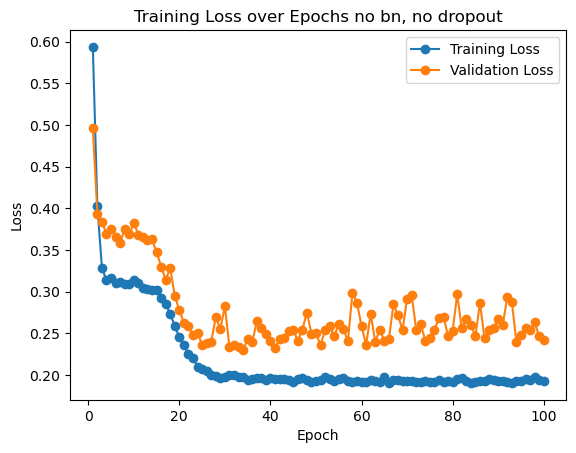

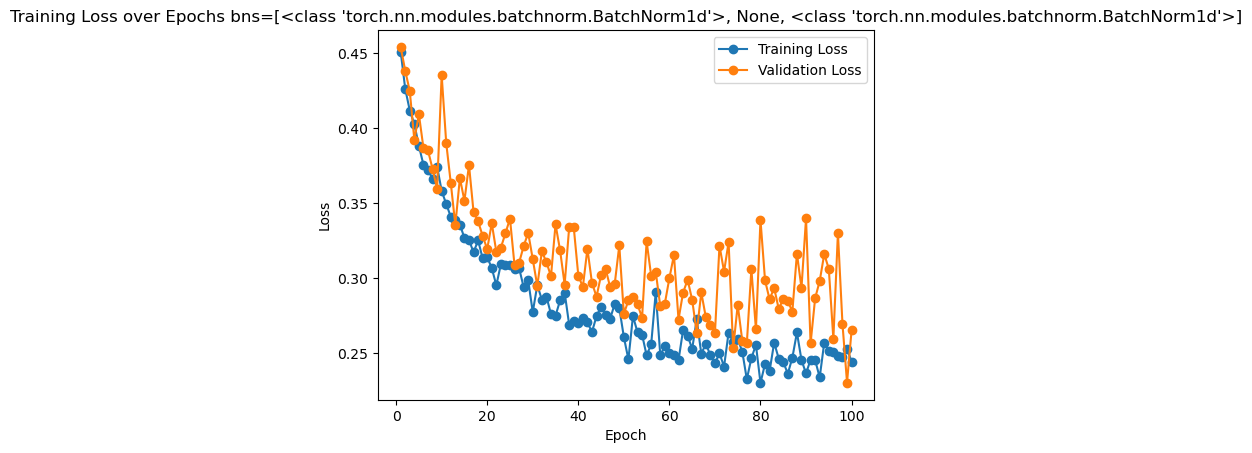

In [12]:
layers = [2, 50, 50, 1]
activations = [nn.Hardswish(), nn.GELU(), nn.Sigmoid()]
bns = [nn.BatchNorm1d,None,nn.BatchNorm1d]
testModel(
    layers=layers, 
    activations=activations,
    epochs=100, 
    output=False,
    title_addon='no bn, no dropout'
    )
testModel(
    layers=layers, 
    activations=activations,
    batchnorms=bns,
    epochs=100, 
    output=False,
    title_addon=f'{bns=}'
    )


C:\Users\Admin\AppData\Local\Temp\ipykernel_38700\293244706.py:3: UserWarning: Number of activations doesn't correspond to number of layers.
  warnings.warn("Number of activations doesn't correspond to number of layers.")


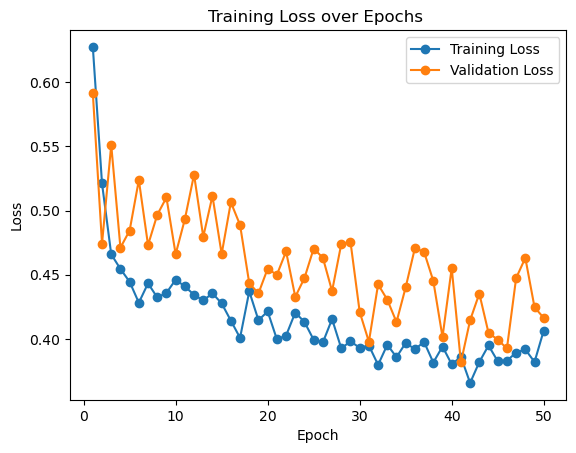

In [13]:
layers = [2, 50, 50, 1]
activations = [nn.Hardswish(), nn.GELU()]
dropouts = [0.3, 0., 0.7]
testModel(
    layers=layers, 
    activations=activations,
    epochs=50, 
    output=False,
    dropouts=dropouts
    )


In [14]:
# TODO paper batchnorm v. dropout: https://www.researchgate.net/publication/338741810_Dropout_vs_batch_normalization_an_empirical_study_of_their_impact_to_deep_learning/link/632bb4a870cc936cd327a358/download